# **Final Project - Image Classification**

- **Nama:** Muhammad Suhaili
- **Email:** aleeeinnntwo@gmail.com
- **ID Dicoding:** msuhaili

In [7]:
import torch
print(torch.__version__) #current version
print(torch.cuda.is_available()) #check if GPU is available

2.4.0+cu121
True


In [8]:
import os
import zipfile
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **Data Preparation**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
from PIL import Image
from collections import defaultdict

dataset_dir = '/content/datafixed/datafixed'

# Dictionary to store resolutions and corresponding image paths
resolution_dict = defaultdict(list)

# Iterate through each subfolder (category)
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)

    # Check if it's a directory
    if os.path.isdir(category_path):
        # Iterate through each image in the category folder
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)

            # Open the image and get its resolution
            with Image.open(image_path) as img:
                resolution = img.size  # (width, height)
                resolution_dict[resolution].append(image_path)

# Check for resolutions with more than one image
print("=== Resolutions Summary ===")
duplicate_count = 0
for resolution, images in resolution_dict.items():
    if len(images) > 1:
        print(f"Resolution {resolution} is shared by {len(images)} images")
        duplicate_count += len(images)

if duplicate_count > 0:
    print(f"Total number of images with duplicated resolutions: {duplicate_count}")
else:
    print("All images have unique resolutions.")

=== Resolutions Summary ===
Resolution (64, 64) is shared by 7249 images
Resolution (256, 256) is shared by 6438 images
Total number of images with duplicated resolutions: 13687


In [12]:
# Create an instance of ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)  # 20% of the data will be used as validation data

# Create an instance of ImageDataGenerator for validation data (without augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# Generate batches of augmented data for training
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',  # Use the training subset
    seed=1000)

# Generate batches of data for validation (without augmentation)
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Use the validation subset
    seed=1000)

Found 10952 images belonging to 4 classes.
Found 2735 images belonging to 4 classes.


In [14]:
# Labels with their class names
class_labels = {class_name: i for i, class_name in enumerate(train_generator.class_indices)}
print(class_labels)

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


## **Modeling**

In [15]:
# Define the model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax')) # 4 classes

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 63, 63, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,711,268 (14.16 MB)

 Trainable params: 3,711,268 (14.16 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Define class for early stopping
class EarlyStopping(keras.callbacks.Callback):
    def __init__(self,
                 threshold,
                 patience=2,
                 restore_best_weights='True'):
        super(EarlyStopping, self).__init__()
        self.threshold = threshold

    # Applying early callback
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [19]:
# Training will stop when validation acc reaches 0.97
mycallback = EarlyStopping(threshold=0.96)
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=30,
                    verbose=2,
                    callbacks=[mycallback])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


343/343 - 22s - 63ms/step - accuracy: 0.8401 - loss: 0.3945 - val_accuracy: 0.8779 - val_loss: 0.3041
Epoch 2/30
343/343 - 10s - 28ms/step - accuracy: 0.8890 - loss: 0.2964 - val_accuracy: 0.9316 - val_loss: 0.2267
Epoch 3/30
343/343 - 12s - 34ms/step - accuracy: 0.9130 - loss: 0.2334 - val_accuracy: 0.9389 - val_loss: 0.1643
Epoch 4/30
343/343 - 11s - 32ms/step - accuracy: 0.9268 - loss: 0.2011 - val_accuracy: 0.9503 - val_loss: 0.1479
Epoch 5/30
343/343 - 20s - 57ms/step - accuracy: 0.9385 - loss: 0.1651 - val_accuracy: 0.9331 - val_loss: 0.1636
Epoch 6/30
343/343 - 11s - 33ms/step - accuracy: 0.9396 - loss: 0.1667 - val_accuracy: 0.9415 - val_loss: 0.1538
Epoch 7/30
343/343 - 20s - 60ms/step - accuracy: 0.9517 - loss: 0.1337 - val_accuracy: 0.9517 - val_loss: 0.1294
Epoch 8/30
343/343 - 19s - 54ms/step - accuracy: 0.9570 - loss: 0.1207 - val_accuracy: 0.9580 - val_loss: 0.1356
Epoch 9/30
343/343 - 13s - 37ms/step - accuracy: 0.9615 - loss: 0.1029 - val_accuracy: 0.9693 - val_loss: 0

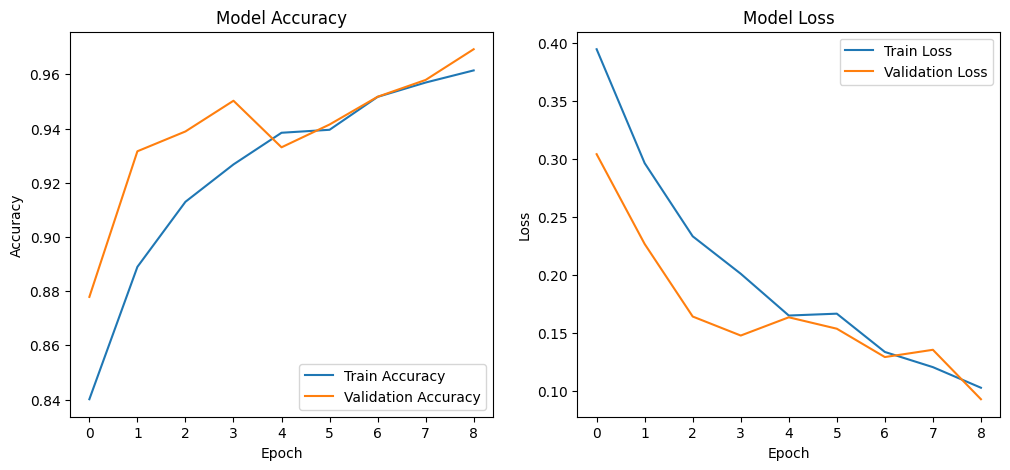

In [20]:
# Plotting accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Display the plots
plt.show()

## **Konversi Model**

### **Saved Model**

In [21]:
save_path = '/content/drive/MyDrive/Dicoding/finalproject/saved_model/'
tf.saved_model.save(model, save_path)

### **TensorflowJS**

Pastikan bahwa TensorflowJS sudah terinstall dengan baik.

In [22]:
!saved_model_cli show --dir saved_model --tag_set serve --signature_def serving_default

2024-09-08 10:25:00.309030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 10:25:00.342946: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 10:25:00.354147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 10:25:01.805142: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1725791103.243699    3866 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/b

In [23]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 117.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [24]:
!tensorflowjs_converter --input_format=tf_saved_model '/content/drive/MyDrive/Dicoding/finalproject/saved_model/' '/content/drive/MyDrive/Dicoding/finalproject/tfjs_model/'

2024-09-08 10:25:51.986482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 10:25:52.018957: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 10:25:52.028787: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 10:25:53.589025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1725791156.456705    4131 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/b

### **tflite & inference example**

In [25]:
model.save("h5_model.h5")

In [26]:
keras_model = tf.keras.models.load_model("/content/h5_model.h5")

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)

In [28]:
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpds5n__xp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139869606181200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139869606175040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139869606317744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139869606329008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139869606586224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139869606580944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139869606586400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139869606589920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139869606590624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139869606591152: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [29]:
with open('/content/drive/MyDrive/Dicoding/finalproject/tflite/model.tflite', 'wb') as f:
  f.write(tflite_model)

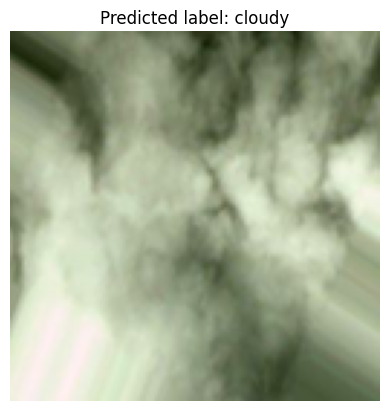

In [31]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Inference
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Dicoding/finalproject/tflite/model.tflite")
interpreter.allocate_tensors()

# Load label file
with open("/content/drive/MyDrive/Dicoding/finalproject/tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preprocess the image
def preprocess_image(image_path, input_shape):
    img = Image.open(image_path)
    img = img.resize((input_shape[1], input_shape[2]))  # Resize to match the model input size
    img_array = np.array(img).astype('float32')  # Convert to float32
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img, img_array

# Load and preprocess the image
image_path = "/content/drive/MyDrive/Dicoding/finalproject/test_image.jpeg"  # Path to the image you want to classify
input_shape = input_details[0]['shape']  # Input shape required by the model
img, img_array = preprocess_image(image_path, input_shape)

# Set the tensor to the model
interpreter.set_tensor(input_details[0]['index'], img_array)

# Run the inference
interpreter.invoke()

# Get the output
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class_index = np.argmax(output_data)

# Get the corresponding label
predicted_label = labels[predicted_class_index]

# Display the image with the predicted label
plt.imshow(img)
plt.title(f"Predicted label: {predicted_label}")
plt.axis('off')  # Turn off axis labels
plt.show()

In [32]:
!pip freeze > /content/drive/MyDrive/Dicoding/finalproject/requirements.txt